In [ ]:
!pip install pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 48.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive, files

import numpy as np
import pandas as pd

import scipy as sc

import matplotlib.pyplot as plt

import torch
import pytorch_lightning

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# df = pd.read_csv('daily.csv', index_col = 'time')
# df.index = pd.to_datetime(df.index)
# df = df.drop(['inquiry_time', 'reply_time', 'accepted_time', 'booking_time'], axis = 1)

df_master = pd.read_csv('master.csv')

In [ ]:
def generate_dataset(df_master: pd.DataFrame,
                     listing_neighborhoods: list = None,
                     guest_country: list = None,
                     host_country: list = None,
                     interval: str = 'hour',
                     look_back: int = 1):

  df = df_master.copy()

  if listing_neighborhoods is not None:
    mask = df['listing_neighborhood'].isin(listing_neighborhoods)
    df = df[mask].reset_index()

  if guest_country is not None:
    mask = df['guest_country'].isin(guest_country)
    df = df[mask].reset_index()

  if host_country is not None:
    mask = df['host_country'].isin(host_country)
    df = df[mask].reset_index()

  # Convert timestamps to datetimes
  df.ts_interaction_first = pd.to_datetime(df.ts_interaction_first) # .dt.floor('D' if interval == 'day' else 'H')
  df.ts_reply_at_first = pd.to_datetime(df.ts_reply_at_first) # .dt.floor('D' if interval == 'day' else 'H')
  df.ts_accepted_at_first = pd.to_datetime(df.ts_accepted_at_first) # .dt.floor('D' if interval == 'day' else 'H')
  df.ts_booking_at = pd.to_datetime(df.ts_booking_at) # .dt.floor('D' if interval == 'day' else 'H')

  # Get min and max times
  max_time = min(max(df.ts_interaction_first), max(df.ts_reply_at_first), max(df.ts_accepted_at_first), max(df.ts_booking_at))
  min_time = max(min(df.ts_interaction_first), min(df.ts_reply_at_first), min(df.ts_accepted_at_first), min(df.ts_booking_at))

  time = pd.date_range(start = min_time, end = max_time, freq = '1D' if interval == 'day' else '1H')

  N = len(time)

  zeros_ = np.zeros((N-1,))
  nans_ = np.ones((N-1,)) * np.nan

  df_interval = pd.DataFrame({# inquires
                              'total_inquiries': zeros_,
                              'total_home_inquiries': zeros_,
                              'total_shared_inquiries': zeros_,
                              'total_private_inquiries': zeros_,
                              'guest_rate': zeros_,
                              'guest_return_rate': zeros_,
                              'host_return_rate': zeros_,
                              'interaction_rate': zeros_,
                              'message_rate': zeros_,
                              'total_contact_me': zeros_,
                              'total_book_it': zeros_,
                              'total_instant_book': zeros_,
                              'pct_contact_me': zeros_,
                              'pct_book_it': zeros_,
                              'pct_instant_book': zeros_,
                              'pct_past_booker': zeros_,
                              'pct_new_user': zeros_,
                              # replies
                              'total_replies': zeros_,
                              'reply_rate': zeros_,
                              'avg_reply_time': nans_,
                              # accepted
                              'total_accepted': zeros_,
                              'accepted_rate': zeros_,
                              'avg_accepted_time': nans_,
                              # booking
                              'total_booking': zeros_,
                              'booking_rate': zeros_,
                              'avg_booking_time': nans_},
                              index = time[1:])

  inquiry_idx_I = []

  for i in range(1, len(time)):
    min_time_i, max_time_i = time[i-1], time[i]

    interval_len = sum((df.ts_interaction_first > min_time_i) & (df.ts_interaction_first <= max_time_i))

    inquiry_idx_i = np.where(~df.ts_interaction_first.isnull() & (df.ts_interaction_first > min_time_i) & (df.ts_interaction_first <= max_time_i))[0]
    reply_idx_i = np.where(~df.ts_reply_at_first.isnull() & (df.ts_reply_at_first > min_time_i) & (df.ts_reply_at_first <= max_time_i))[0]
    accepted_idx_i = np.where(~df.ts_accepted_at_first.isnull() & (df.ts_accepted_at_first > min_time_i) & (df.ts_accepted_at_first <= max_time_i))[0]
    booking_idx_i = np.where(~df.ts_booking_at.isnull() & (df.ts_booking_at > min_time_i) & (df.ts_booking_at <= max_time_i))[0]

    inquiry_idx_I.append(inquiry_idx_i)

    # number of inquiries
    df_interval.total_inquiries[i-1] = len(inquiry_idx_i)

    df_interval.total_home_inquiries[i-1] = sum(df.room_type[inquiry_idx_i] == 'Entire home/apt')
    df_interval.total_shared_inquiries[i-1] = sum(df.room_type[inquiry_idx_i] == 'Shared room')
    df_interval.total_private_inquiries[i-1] = sum(df.room_type[inquiry_idx_i] == 'Private room')

    # Guests per inquiry
    df_interval.guest_rate[i-1] = df.m_guests[inquiry_idx_i].sum() / df_interval.total_inquiries[i-1]

    if len(inquiry_idx_I) > 1:
      inquiry_idx_prev = np.concatenate(inquiry_idx_I[-(look_back+1):-1])

      total_guest_repeat = len(set(df.id_guest_anon[inquiry_idx_prev]) & set(df.id_guest_anon[inquiry_idx_i]))
      df_interval.guest_return_rate[i-1] = total_guest_repeat / len(np.unique(df.id_guest_anon[inquiry_idx_i]))

      total_host_repeat = len(set(df.id_host_anon[inquiry_idx_prev]) & set(df.id_host_anon[inquiry_idx_i]))
      df_interval.host_return_rate[i-1] = total_host_repeat / len(np.unique(df.id_host_anon[inquiry_idx_i]))

    # Interaction rate
    df_interval.interaction_rate[i-1] = np.sum(df.m_interactions[inquiry_idx_i]) / df_interval.total_inquiries[i-1]

    # Message length by inquiry
    df_interval.message_rate[i-1] = df.m_first_message_length_in_characters[inquiry_idx_i].sum() / df_interval.total_inquiries[i-1]

    # number of 'contact me', 'book it', and 'instant book' inquires
    df_interval.total_contact_me[i-1] = sum(df.contact_channel_first[inquiry_idx_i] == 'contact_me')
    df_interval.total_book_it[i-1] = sum(df.contact_channel_first[inquiry_idx_i] == 'book_it')
    df_interval.total_instant_book[i-1] = sum(df.contact_channel_first[inquiry_idx_i] == 'instant_book')

    # Percent of inquiries in each channel
    df_interval.pct_contact_me[i-1] = df_interval.total_contact_me[i-1] / df_interval.total_inquiries[i-1]
    df_interval.pct_book_it[i-1] = df_interval.total_book_it[i-1] / df_interval.total_inquiries[i-1]
    df_interval.pct_instant_book[i-1] = df_interval.total_instant_book[i-1] / df_interval.total_inquiries[i-1]

    # Percent of inquiries made by past booker or new user
    df_interval.pct_past_booker[i-1] = sum(df.guest_user_stage_first[inquiry_idx_i] == 'past_booker') / df_interval.total_inquiries[i-1]
    df_interval.pct_new_user[i-1] = sum(df.guest_user_stage_first[inquiry_idx_i] == 'new') / df_interval.total_inquiries[i-1]

    # number replied
    df_interval.total_replies[i-1] = len(reply_idx_i)

    # host reply rate
    df_interval.reply_rate[i-1] = df_interval.total_replies[i-1] / df_interval.total_inquiries[i-1]

    # average reply time
    df_interval.avg_reply_time[i-1] = np.nanmean((df.ts_reply_at_first[reply_idx_i] - df.ts_interaction_first[reply_idx_i]).dt.seconds)
    df_interval.avg_reply_time[i-1] /= (3600*24) if interval == 'day' else 3600

    # number accepted
    df_interval.total_accepted[i-1] = len(accepted_idx_i)

    # host accepted rate
    df_interval.accepted_rate[i-1] = df_interval.total_accepted[i-1] / df_interval.total_inquiries[i-1]

    # average accepted time
    df_interval.avg_accepted_time[i-1] = np.nanmean((df.ts_accepted_at_first[accepted_idx_i] - df.ts_interaction_first[accepted_idx_i]).dt.seconds)
    df_interval.avg_accepted_time[i-1] /= (3600*24) if interval == 'day' else 3600

    # number booked
    df_interval.total_booking[i-1] = len(booking_idx_i)

    # host booking rate
    df_interval.booking_rate[i-1] = df_interval.total_booking[i-1] / df_interval.total_inquiries[i-1]

    # average booking time
    df_interval.avg_booking_time[i-1] = np.nanmean((df.ts_booking_at[booking_idx_i] - df.ts_interaction_first[booking_idx_i]).dt.seconds)
    df_interval.avg_booking_time[i-1] /= (3600*24) if interval == 'day' else 3600

  return df_interval


In [ ]:
def generate_dataset(df_master: pd.DataFrame,
                     listing_neighborhoods: list = None,
                     guest_country: list = None,
                     host_country: list = None,
                     interval: str = 'hour',
                     look_back: int = 1):

  df = df_master.copy()

  if listing_neighborhoods is not None:
    mask = df['listing_neighborhood'].isin(listing_neighborhoods)
    df = df[mask].reset_index()

  if guest_country is not None:
    mask = df['guest_country'].isin(guest_country)
    df = df[mask].reset_index()

  if host_country is not None:
    mask = df['host_country'].isin(host_country)
    df = df[mask].reset_index()

  # Convert timestamps to datetimes
  df.ts_interaction_first = pd.to_datetime(df.ts_interaction_first) # .dt.floor('D' if interval == 'day' else 'H')
  df.ts_reply_at_first = pd.to_datetime(df.ts_reply_at_first) # .dt.floor('D' if interval == 'day' else 'H')
  df.ts_accepted_at_first = pd.to_datetime(df.ts_accepted_at_first) # .dt.floor('D' if interval == 'day' else 'H')
  df.ts_booking_at = pd.to_datetime(df.ts_booking_at) # .dt.floor('D' if interval == 'day' else 'H')

  # Get min and max times
  max_time = min(max(df.ts_interaction_first), max(df.ts_reply_at_first), max(df.ts_accepted_at_first), max(df.ts_booking_at))
  min_time = max(min(df.ts_interaction_first), min(df.ts_reply_at_first), min(df.ts_accepted_at_first), min(df.ts_booking_at))

  time = pd.date_range(start = min_time, end = max_time, freq = '1D' if interval == 'day' else '1H')

  N = len(time)

  zeros_ = np.zeros((N-1,))
  nans_ = np.ones((N-1,)) * np.nan

  df_interval = pd.DataFrame({'total_inquiries': zeros_,
                              'total_replies': zeros_,
                              'total_accepted': zeros_,
                              'total_booking': zeros_,
                              'contact_me_rate': zeros_,
                              'book_it_rate': zeros_,
                              'instant_book_rate': zeros_,
                              'guest_return_rate': zeros_,
                              'guest_message_rate': zeros_,
                              'words_in_guest_profile': zeros_,
                              'reply_rate': zeros_,
                              'reply_time': nans_,
                              'accepted_rate': zeros_,
                              'accepted_time': nans_,
                              'reply_conversion_rate': zeros_,
                              'accepted_conversion_rate': zeros_,
                              'booking_rate': zeros_,
                              'booking_time': nans_,
                              'listing_rate': zeros_,
                              'interaction': zeros_},
                              index = time[1:])

  inquiry_idx_I = []


  for i in range(1, len(time)):
    min_time_i, max_time_i = time[i-1], time[i]

    interval_len = sum((df.ts_interaction_first > min_time_i) & (df.ts_interaction_first <= max_time_i))

    inquiry_idx_i = np.where(~df.ts_interaction_first.isnull() & (df.ts_interaction_first > min_time_i) & (df.ts_interaction_first <= max_time_i))[0]
    reply_idx_i = np.where(~df.ts_reply_at_first.isnull() & (df.ts_reply_at_first > min_time_i) & (df.ts_reply_at_first <= max_time_i))[0]
    accepted_idx_i = np.where(~df.ts_accepted_at_first.isnull() & (df.ts_accepted_at_first > min_time_i) & (df.ts_accepted_at_first <= max_time_i))[0]
    booking_idx_i = np.where(~df.ts_booking_at.isnull() & (df.ts_booking_at > min_time_i) & (df.ts_booking_at <= max_time_i))[0]

    total_contact_me_i = sum(df.contact_channel_first[inquiry_idx_i] == 'contact_me')
    total_book_it_i = sum(df.contact_channel_first[inquiry_idx_i] == 'book_it')
    total_instant_book_i = sum(df.contact_channel_first[inquiry_idx_i] == 'instant_book')

    total_inquiries_i = len(inquiry_idx_i)
    total_replies_i = len(reply_idx_i)
    total_accepted_i = len(accepted_idx_i)
    total_booking_i = len(booking_idx_i)

    inquiry_idx_I.append(inquiry_idx_i)

    # total inquiries
    df_interval.loc[df_interval.index[i-1], 'total_inquiries'] = total_inquiries_i
    # total replies
    df_interval.loc[df_interval.index[i-1], 'total_replies'] = total_replies_i
    # total accepted
    df_interval.loc[df_interval.index[i-1], 'total_accepted'] = total_accepted_i
    # total booking
    df_interval.loc[df_interval.index[i-1], 'total_booking'] = total_booking_i

    # 'contact me' rate
    df_interval.loc[df_interval.index[i-1], 'contact_me_rate'] = total_contact_me_i / total_inquiries_i
    # 'book it' rate
    df_interval.loc[df_interval.index[i-1], 'book_it_rate'] = total_book_it_i / total_inquiries_i
    # 'instant book' rate
    df_interval.loc[df_interval.index[i-1], 'instant_book_rate'] = total_instant_book_i / total_inquiries_i

    # guest return rate
    past_booker_idx_i = inquiry_idx_i[np.where(df.guest_user_stage_first[inquiry_idx_i] == 'past_booker')[0]]
    df_interval.loc[df_interval.index[i-1], 'guest_return_rate'] = df.id_guest_anon[past_booker_idx_i].unique().size / df.id_guest_anon[inquiry_idx_i].unique().size

    # guest message rate
    df_interval.loc[df_interval.index[i-1], 'guest_message_rate'] = df.m_first_message_length_in_characters[inquiry_idx_i].sum() / total_inquiries_i

    # guest profile length
    df_interval.loc[df_interval.index[i-1], 'words_in_guest_profile'] = df.words_in_guest_profile[inquiry_idx_i].mean()

    # reply rate
    df_interval.loc[df_interval.index[i-1], 'reply_rate']  = total_replies_i / total_inquiries_i
    # reply time
    df_interval.loc[df_interval.index[i-1], 'reply_time'] = (df.ts_reply_at_first[inquiry_idx_i] - df.ts_interaction_first[inquiry_idx_i]).dropna().mean().seconds
    df_interval.loc[df_interval.index[i-1], 'reply_time'] /= 3600 if interval == 'hour' else 3600*24

    # accepted rate
    df_interval.loc[df_interval.index[i-1], 'accepted_rate']  = total_accepted_i / total_inquiries_i
    # accepted time
    df_interval.loc[df_interval.index[i-1], 'accepted_time'] = (df.ts_accepted_at_first[inquiry_idx_i] - df.ts_interaction_first[inquiry_idx_i]).dropna().mean().seconds
    df_interval.loc[df_interval.index[i-1], 'accepted_time'] /= 3600 if interval == 'hour' else 3600*24

    # booking rate
    df_interval.loc[df_interval.index[i-1], 'booking_rate']  = total_booking_i / total_inquiries_i
    # booking time
    df_interval.loc[df_interval.index[i-1], 'booking_time'] = (df.ts_booking_at[inquiry_idx_i] - df.ts_interaction_first[inquiry_idx_i]).dropna().mean().seconds
    df_interval.loc[df_interval.index[i-1], 'booking_time'] /= 3600 if interval == 'hour' else 3600*24

    # reply conversion rate
    df_interval.loc[df_interval.index[i-1], 'reply_conversion_rate'] = total_booking_i / total_replies_i

    # accepted conversion rate
    df_interval.loc[df_interval.index[i-1], 'accepted_conversion_rate'] = total_booking_i / total_accepted_i

    # listing rate
    df_interval.loc[df_interval.index[i-1], 'listing_rate'] = len(df.id_listing_anon[inquiry_idx_i].unique())/len(df.id_guest_anon[inquiry_idx_i].unique())

    # interaction
    df_interval.loc[df_interval.index[i-1], 'interaction'] = df.m_interactions[inquiry_idx_i].sum()/len(set(df.id_guest_anon[inquiry_idx_i]) | set(df.id_host_anon[inquiry_idx_i]))

  return df_interval


In [ ]:

df_day = generate_dataset(df_master,
                          interval = 'day')

# df_day.to_csv('/content/drive/MyDrive/IK/data/takehome/daily_metrics.csv', index = True)


Text(0.5, 0, 'Date')

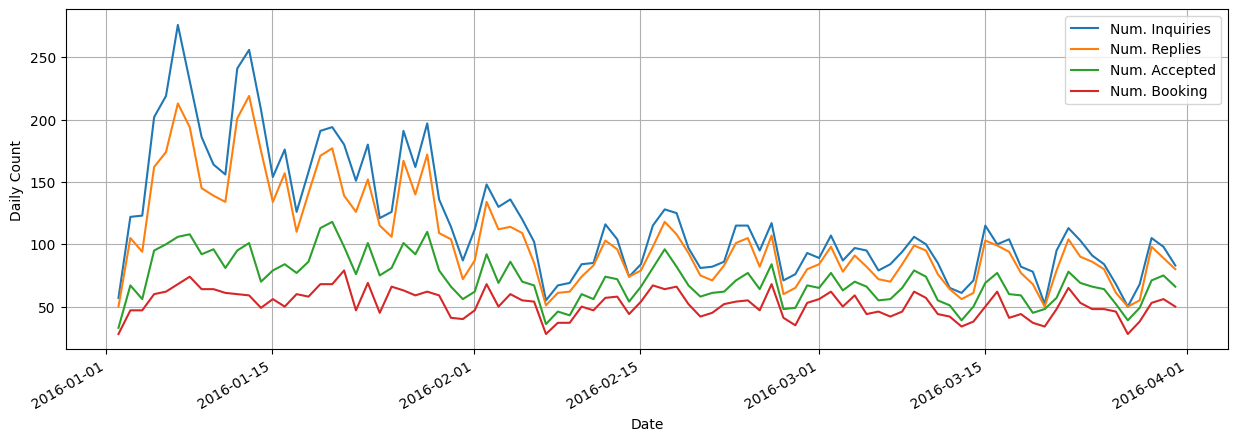

In [ ]:
df_day[['total_inquiries', 'total_replies', 'total_accepted', 'total_booking']][df_day.index < '2016-04'].plot(kind = 'line',
                                                                                                               grid = True,
                                                                                                               figsize = (15, 5)) ;

# Set legend labels
plt.legend(['Num. Inquiries', 'Num. Replies', 'Num. Accepted', 'Num. Booking'])

# Set y-axis label
plt.ylabel('Daily Count')

# Set x-axis label
plt.xlabel('Date')

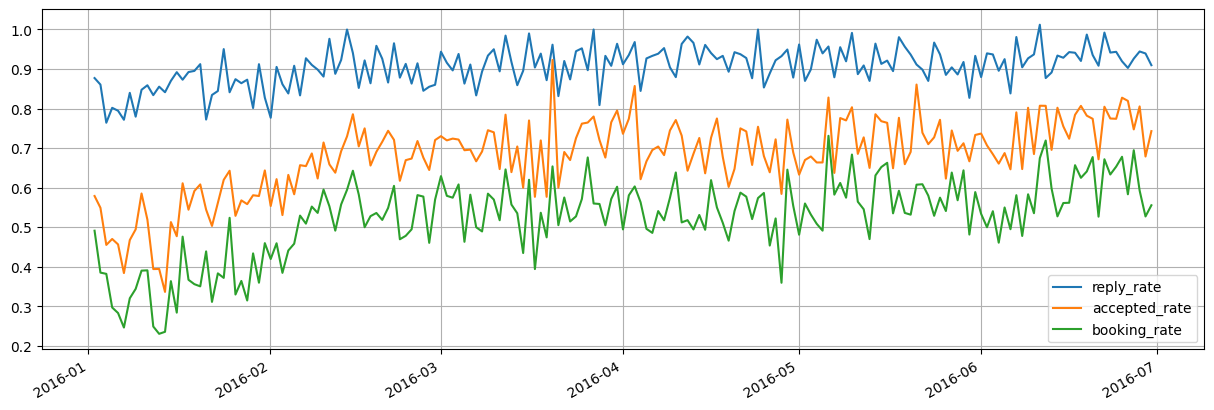

In [ ]:
df_day[['reply_rate', 'accepted_rate', 'booking_rate']].plot(kind = 'line',
                                                             grid = True,
                                                             figsize = (15, 5)) ;

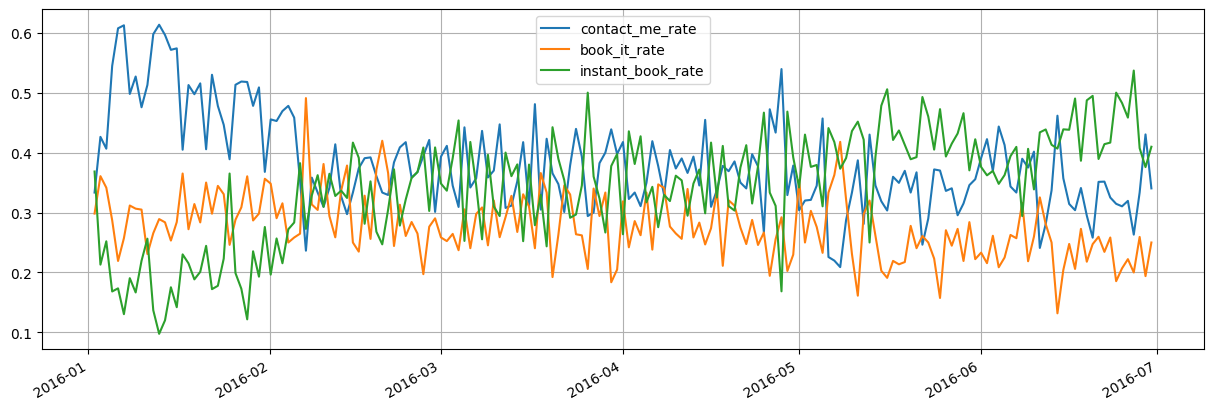

In [ ]:
df_day[['contact_me_rate', 'book_it_rate', 'instant_book_rate']].plot(kind = 'line',
                                                                      grid = True,
                                                                      figsize = (15, 5)) ;

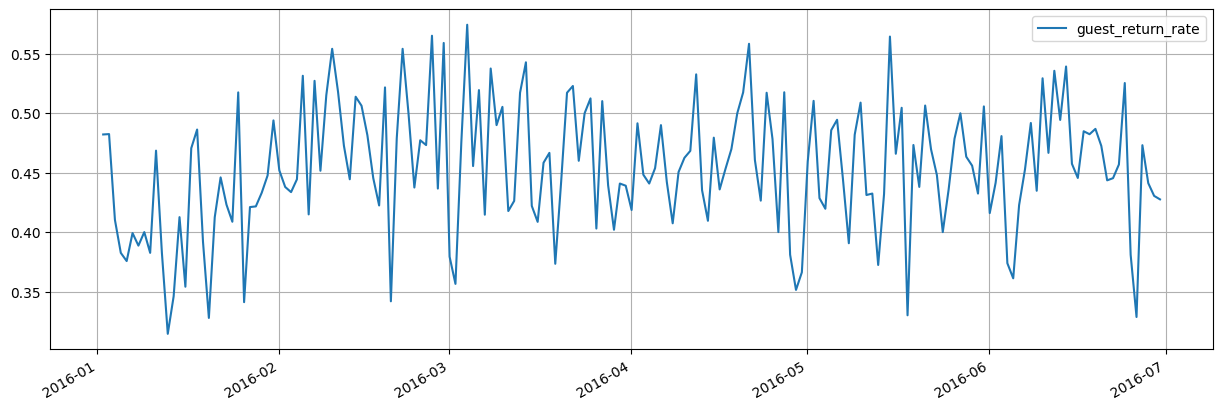

In [ ]:
df_day[['guest_return_rate']].plot(kind = 'line',
                                    grid = True,
                                    figsize = (15, 5)) ;

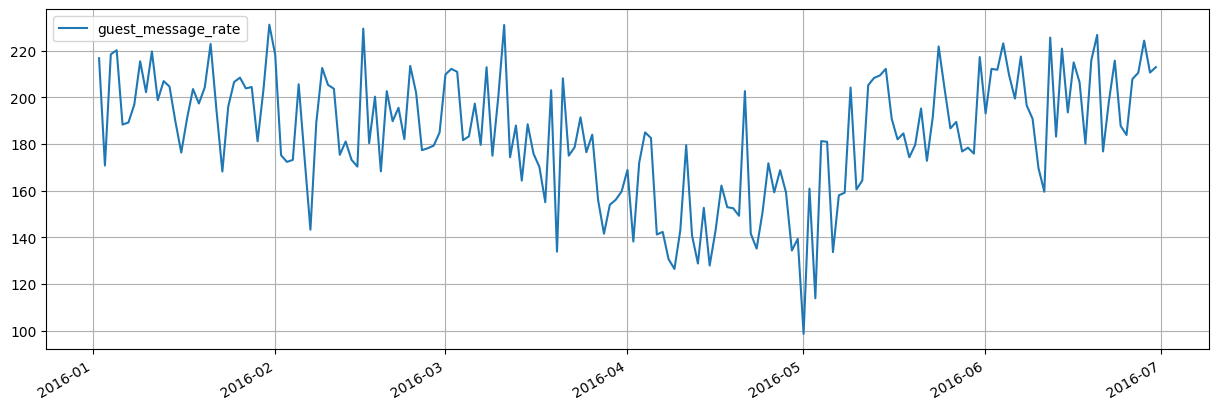

In [ ]:
df_day[['guest_message_rate']].plot(kind = 'line',
                                    grid = True,
                                    figsize = (15, 5)) ;

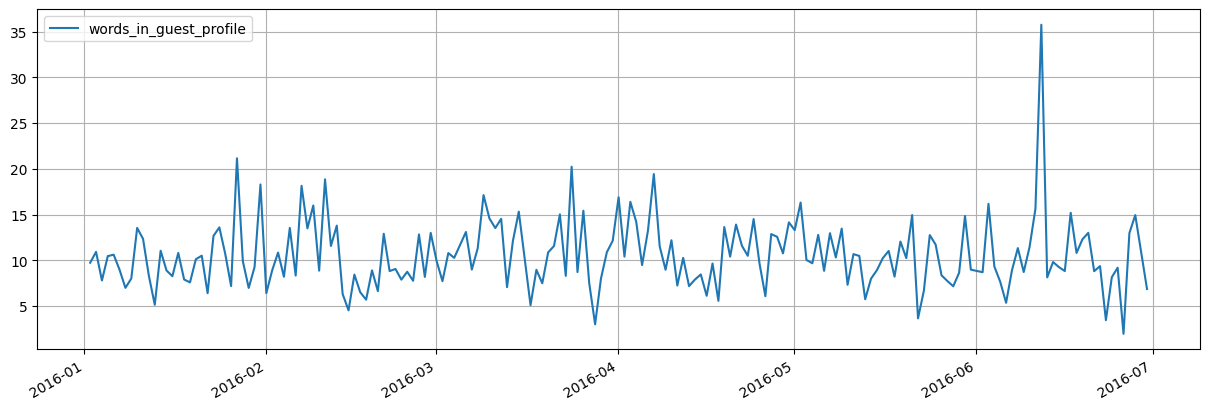

In [ ]:
df_day[['words_in_guest_profile']].plot(kind = 'line',
                                        grid = True,
                                        figsize = (15, 5)) ;

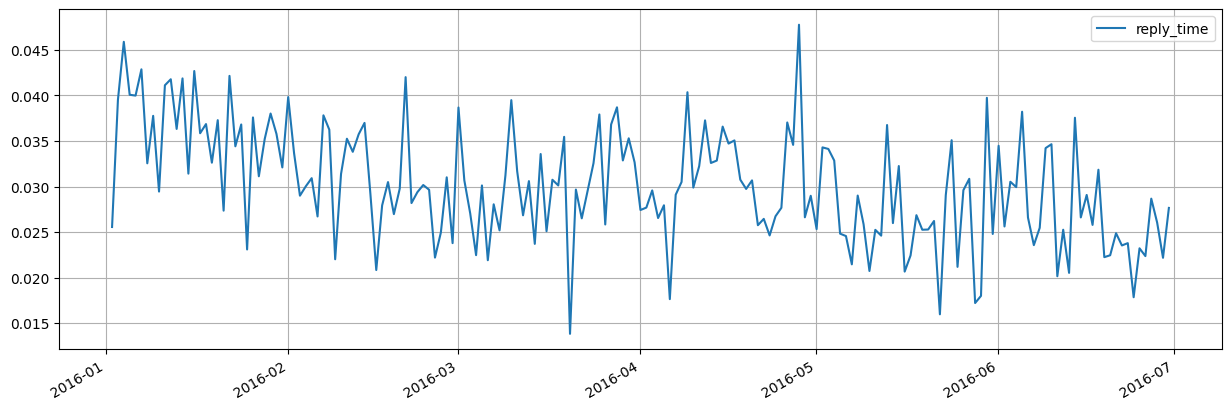

In [ ]:
df_day[['reply_time']].plot(kind = 'line',
                            grid = True,
                            figsize = (15, 5)) ;

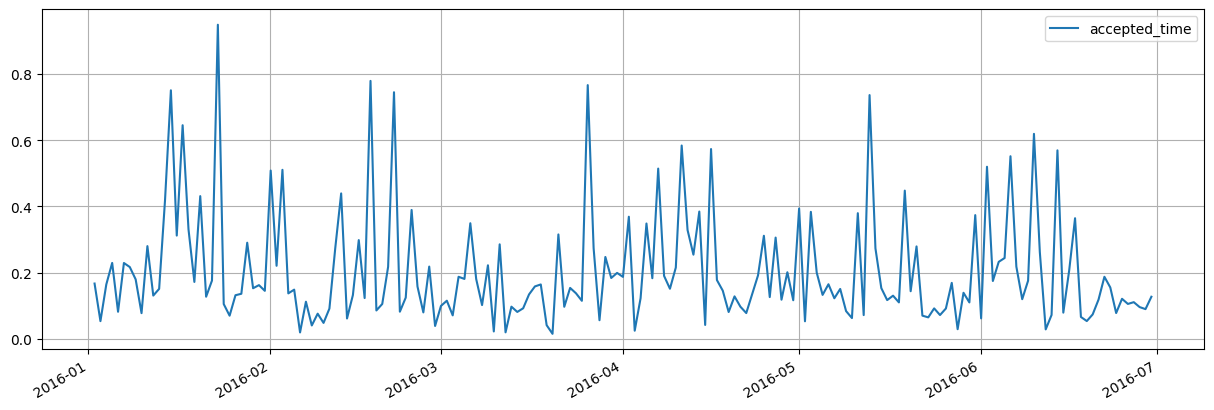

In [ ]:
df_day[['accepted_time']].plot(kind = 'line',
                            grid = True,
                            figsize = (15, 5)) ;

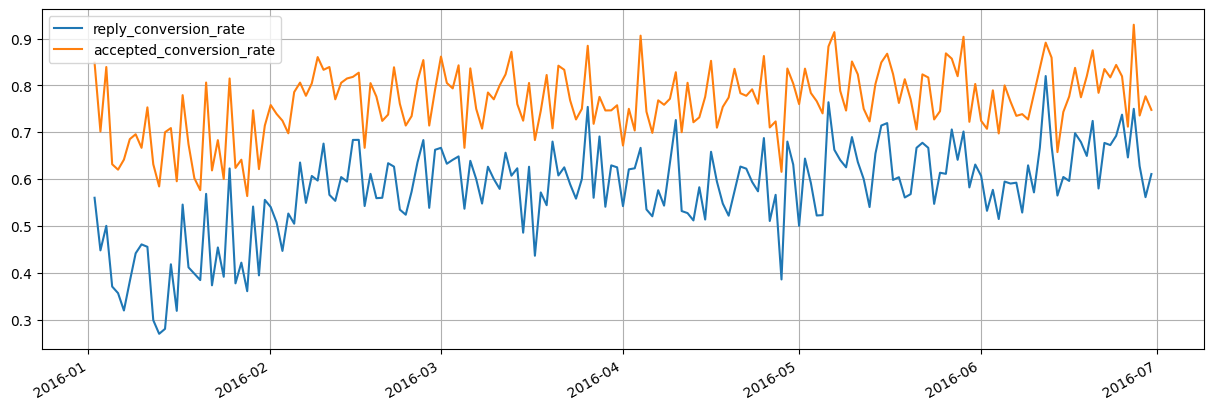

In [ ]:
df_day[['reply_conversion_rate', 'accepted_conversion_rate']].plot(kind = 'line',
                                                                    grid = True,
                                                                    figsize = (15, 5)) ;

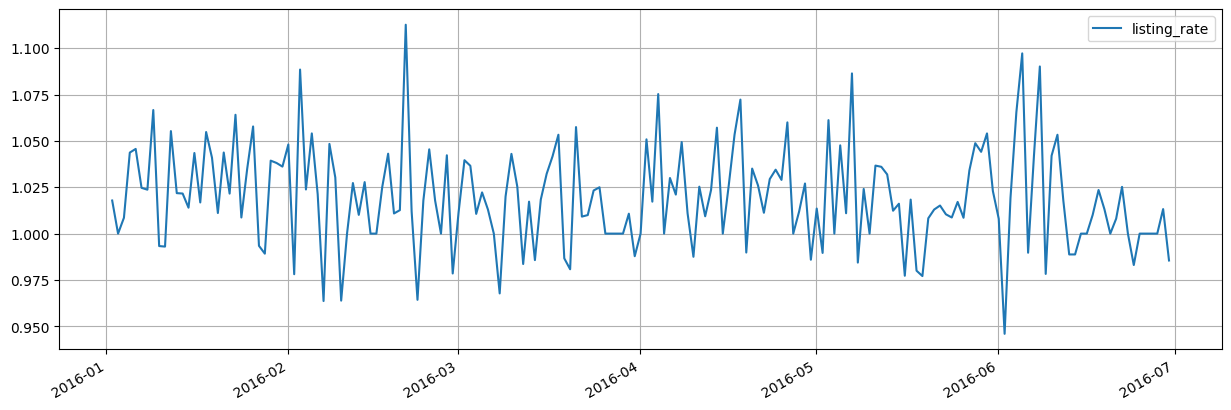

In [ ]:
df_day[['listing_rate']].plot(kind = 'line',
                              grid = True,
                              figsize = (15, 5)) ;

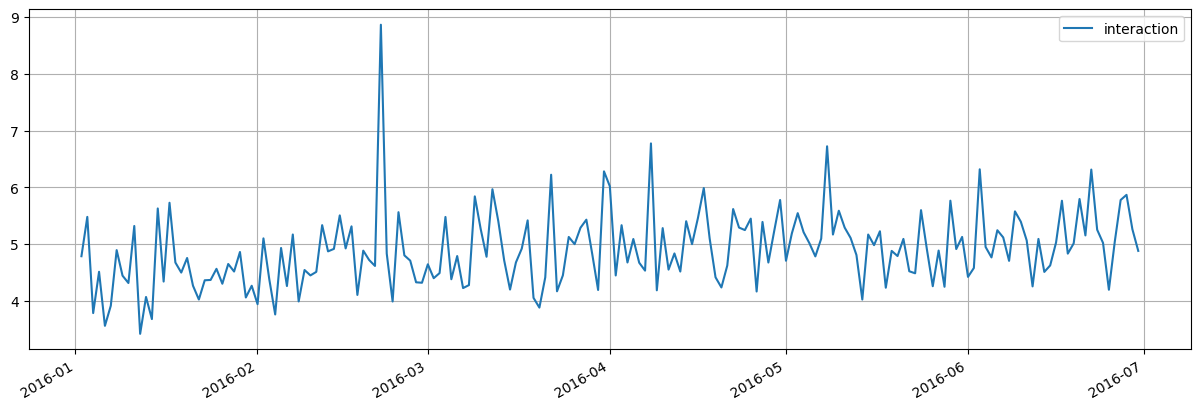

In [ ]:
df_day[['interaction']].plot(kind = 'line',
                              grid = True,
                              figsize = (15, 5)) ;

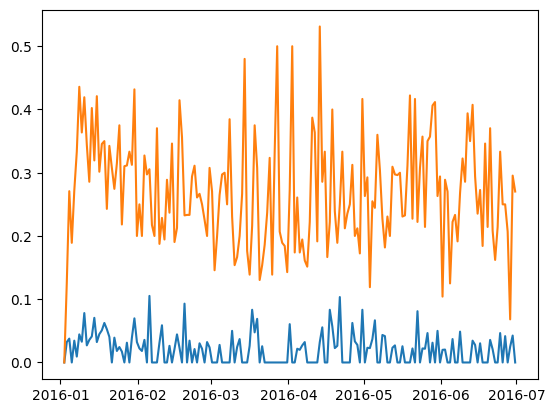

In [ ]:
# plt.plot(df_day['total_inquiries'])
# plt.plot(df_day['total_replies'])
# plt.plot(df_day['total_accepted'])
# plt.plot(df_day['total_booking'])

# plt.plot(df_day['reply_rate'])
# plt.plot(df_day['accepted_rate'])
# plt.plot(df_day['booking_rate'])

# plt.plot(df_day['avg_reply_time'])
# plt.plot(df_day['avg_accepted_time'])
# plt.plot(df_day['avg_booking_time'])

# plt.plot(df_day['total_home_inquiries'])
# plt.plot(df_day['total_shared_inquiries'])
# plt.plot(df_day['total_private_inquiries'])

# plt.plot(df_day['guest_rate'])
# plt.plot(df_day['interaction_rate'])
# plt.plot(df_day['message_rate'])

# plt.plot(df_day['total_contact_me'])
# plt.plot(df_day['total_book_it'])
# plt.plot(df_day['total_instant_book'])

# plt.plot(df_day['pct_contact_me'])
# plt.plot(df_day['pct_book_it'])
# plt.plot(df_day['pct_instant_book'])

# plt.plot(df_day['pct_past_booker'])
# plt.plot(df_day['pct_new_user'])

plt.plot(df_day['guest_return_rate'])
plt.plot(df_day['host_return_rate'])


In [ ]:
import torch
import pandas as pd
import numpy as np

def fft(x, fs = 1, dim = 0, nfft = None, norm = 'backward',
        device = None, dtype = torch.complex64):
  '''
  Computes the Fast Fourier Transform (FFT) of the input signal.

  Args:
      x: The input signal. If not a torch.Tensor, it will be converted to one.
      fs: The sampling frequency of the input signal.
      dim: The dimension(s) along which to compute the FFT.
      nfft: The number of FFT points. If None, it is set to the size of the input signal along the specified dimension.
      norm: The normalization mode. Options are 'backward' (default) and 'forward'.
      device: The device to perform the computation on. If None, the default device is used.
      dtype: The data type of the output.

  Returns:
      freq: The frequency values corresponding to the FFT.
      x_fft_mag: The magnitude of the FFT coefficients.
      x_fft_phase: The phase of the FFT coefficients.
  '''
  if not isinstance(x, torch.Tensor):
      if isinstance(x, pd.core.frame.DataFrame):
          x = x.values
      x = torch.tensor(x).to(device = device, dtype = dtype)

  if nfft is None:
      nfft = x.shape[dim]
      # print(f'nfft set to {nfft}')

  s, dim = [nfft, dim if isinstance(dim, int) else (-2, -1)]

  s += np.mod(s, 2)
  x_fft = torch.fft.fftn(x, s = s, dim = dim, norm = norm).to(device = device,
                                                              dtype = dtype)

  N = int(s // 2)

  if isinstance(dim, int):
      freq = torch.fft.fftfreq(s, d = 1 / fs).to(device = device)[:N]

      x_fft = x_fft.split(N, dim = dim)[0]

      x_fft_mag = 2.0 / s * torch.abs(x_fft)

      x_fft_phase = torch.angle(x_fft)

  elif dim == (-2, -1):
      freq = torch.meshgrid(freq, freq, indexing='ij')

      x_fft_mag = 2 / s * torch.abs(x_fft[..., :N, :N])

      x_fft_phase = torch.angle(x_fft)[..., :N, :N]

  else:
      raise ValueError(f'dim ({dim}) must be 1 or (-2, -1)... for now.')

  return freq, x_fft_mag, x_fft_phase

In [ ]:
def periodogram(X, fs=1, window='hann', nfft=None,
                detrend=None, return_onesided=True,
                scaling='density', axis=0):
  '''
  Computes the periodogram of a signal using the SciPy library.

  Args:
      X: The input signal.
      fs: The sampling frequency of the input signal.
      window: The window function to apply to the signal.
      nfft: The number of points to compute the FFT.
      detrend: The detrend function to remove a trend from the signal.
      return_onesided: If True, returns only the one-sided spectrum for real inputs.
      scaling: The scaling mode for the power spectrum.
      axis: The axis along which to compute the periodogram.

  Returns:
      f: The frequencies at which the periodogram is computed.
      psd: The power spectral density (periodogram) of the signal.
  '''
  if nfft is None:  # or nfft < x.shape[dim]
      nfft = X.shape[axis]
      print(f'nfft set to {nfft}')

  f, psd = sc.signal.periodogram(X, fs=fs, window=window, nfft=nfft,
                          detrend=detrend, return_onesided=return_onesided,
                          scaling=scaling, axis=axis)

  return f, psd

In [ ]:
import torch
import numpy as np

def moving_average(X, window):
    '''
    Applies a moving average filter to the input signal.

    Args:
        X: The input signal (PyTorch tensor).
        window: The window of the moving average filter.

    Returns:
        y: The output signal after applying the moving average filter.
    '''

    if window is None:
      window = np.ones((np.arange(X.shape[0]), 1))

    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X)
    if not isinstance(window, torch.Tensor):
        window = torch.tensor(window).to(X)

    len_window = window.shape[0]

    y = torch.empty_like(X)

    ww = []

    for i in range(X.shape[0]):
        is_odd = int(np.mod(len_window, 2) == 1)

        m = torch.arange((i - (len_window - is_odd) / 2), (i + (len_window - is_odd) / 2 - (is_odd == 0) + 1),
                         dtype=torch.long)

        k = m[(m >= 0) & (m < X.shape[0])]

        window_ = window[(m >= 0) & (m < X.shape[0])]

        window_ /= window_.sum(0)

        y[i] = torch.matmul(window_, X[k])

    return y

<ipython-input-58-ab734ec6bf3c>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_master.groupby('listing_neighborhood').sum().m_interactions.sort_values(ascending = False).plot(kind = 'bar', figsize = (20, 5))


<Axes: xlabel='listing_neighborhood'>

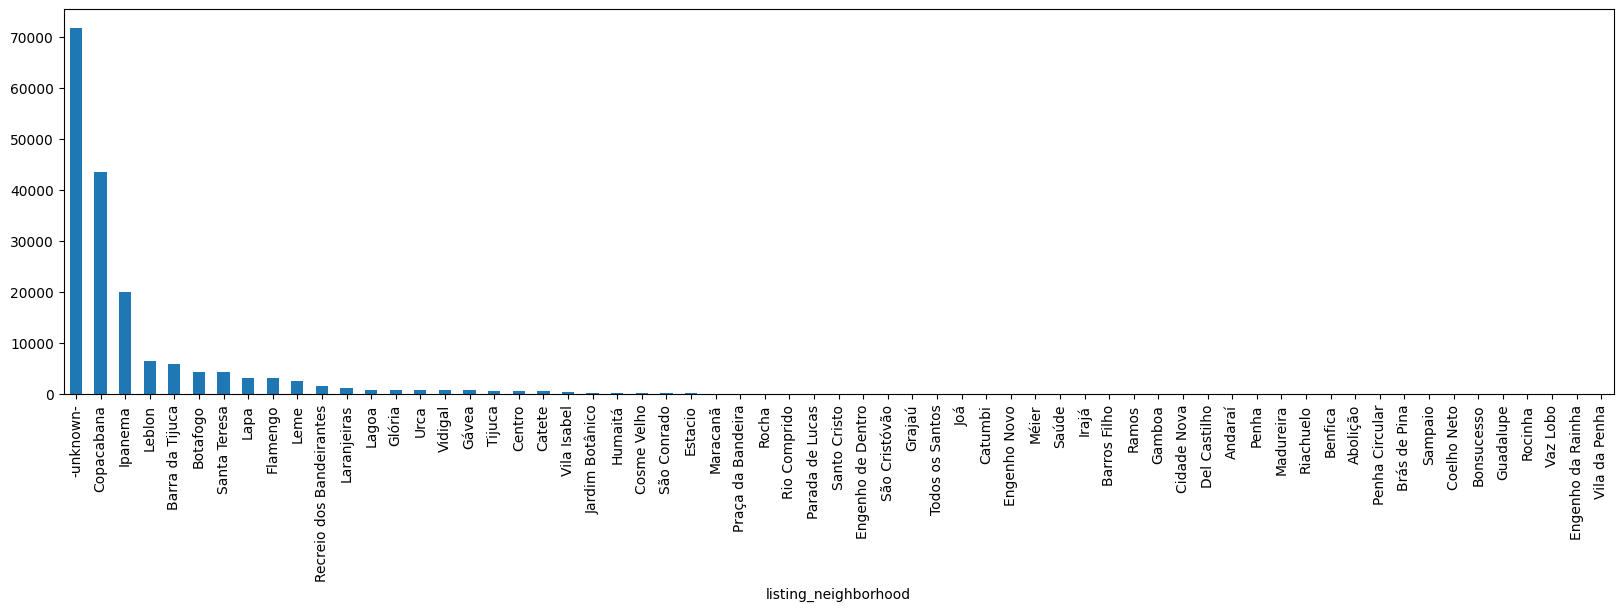

In [ ]:
df_master.groupby('listing_neighborhood').sum().m_interactions.sort_values(ascending = False).plot(kind = 'bar', figsize = (20, 5))

In [ ]:
plt.scatter(df_day['pct_contact_me'],
            df_day['booking_rate'])

plt.scatter(df_day['pct_instant_book'],
            df_day['booking_rate'])

KeyError: ignored

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float32

In [ ]:
data_day = df_day.values.astype(np.float32)
data_day = torch.tensor(data_day).to(device = device,
                                     dtype = dtype)

window = sc.signal.windows.hann(60).astype(np.float32)

data_day_ma = moving_average(data_day, window)

data_v_day = data_day - data_day_ma

freq, psd_data_day = periodogram(data_v_day, fs = 1., window = 'hann', detrend = 'constant')


nfft set to 181


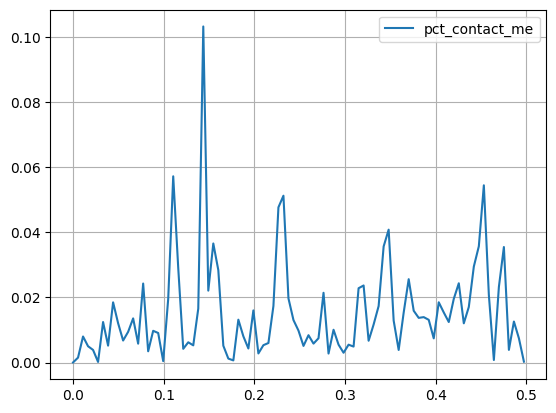

In [ ]:

i = (df_day.columns == 'pct_contact_me').argmax()
plt.plot(freq,
         psd_data_day[:, i], label = df_day.columns[i])
# plt.xlim([0, 0.5])
plt.legend()
plt.grid()

# Find the peaks
peaks, _ = sc.signal.find_peaks(psd_data_day[:, i])

# Sort the peaks by their values in descending order
sorted_peaks = sorted(peaks, key=lambda x: psd_data_day[:, i][x], reverse=True)

# Get the indices of the three highest peaks
n_peaks = 3  # Number of peaks to find
highest_peak_indices = sorted_peaks[:n_peaks]

# total_inquires
# total_contact_me
# total_book_it
# total_instant_book
# total_replies
# total_accepted
# avg_accepted_time
# total_booking
# booking_rate
# avg_booking_time

In [ ]:
freq[highest_peak_indices]

array([0.21546961, 0.10497238, 0.12154696])

In [ ]:
window = sc.signal.windows.hann(30).astype(np.float32)

window = torch.tensor(window).to(device = device,
                                 dtype = dtype)

nfft = 512

# inquiries
inquiries = df_day['total_inquiries'].values.astype(np.float32).reshape(-1,1)
inquiries = torch.tensor(inquiries).to(device = device,
                                       dtype = dtype)
inquiries_ma = moving_average(inquiries, window)
inquiries_v = inquiries - inquiries_ma


# replies
replies = df_day['total_replies'].values.astype(np.float32).reshape(-1,1)
replies = torch.tensor(replies).to(device = device,
                                     dtype = dtype)
replies_ma = moving_average(replies, window)
replies_v = replies - replies_ma

# accepted
accepted = df_day['total_accepted'].values.astype(np.float32).reshape(-1,1)
accepted = torch.tensor(accepted).to(device = device,
                                     dtype = dtype)
accepted_ma = moving_average(accepted, window)
accepted_v = accepted - accepted_ma

# booking
booking = df_day['total_booking'].values.astype(np.float32).reshape(-1,1)
booking = torch.tensor(booking).to(device = device,
                                     dtype = dtype)
booking_ma = moving_average(booking, window)
booking_v = booking - booking_ma

# booking_rate
booking_rate = df_day['booking_rate'].values.astype(np.float32).reshape(-1,1)
booking_rate = torch.tensor(booking_rate).to(device = device,
                                             dtype = dtype)
booking_rate_ma = moving_average(booking_rate, window)
booking_rate_v = booking_rate - booking_rate_ma

# contact_me
contact_me = df_day['total_contact_me'].values.astype(np.float32).reshape(-1,1)
contact_me = torch.tensor(contact_me).to(device = device,
                                         dtype = dtype)
contact_me_ma = moving_average(contact_me, window)
contact_me_v = contact_me - contact_me_ma

# book_it
book_it = df_day['total_book_it'].values.astype(np.float32).reshape(-1,1)
book_it = torch.tensor(book_it).to(device = device,
                                       dtype = dtype)
book_it_ma = moving_average(book_it, window)
book_it_v = book_it - book_it_ma

# instant_book
instant_book = df_day['total_instant_book'].values.astype(np.float32).reshape(-1,1)
instant_book = torch.tensor(instant_book).to(device = device,
                                             dtype = dtype)
instant_book_ma = moving_average(instant_book, window)
instant_book_v = instant_book - instant_book_ma

freq, psd_inquiries = periodogram(inquiries_v, fs = 1., window = 'hann', nfft = nfft, detrend = 'constant')
_, psd_replies = periodogram(replies_v, fs = 1., window = 'hann', nfft = nfft, detrend = 'constant')
_, psd_accepted = periodogram(accepted_v, fs = 1., window = 'hann', nfft = nfft, detrend = 'constant')
_, psd_booking = periodogram(booking_v, fs = 1., window = 'hann', nfft = nfft, detrend = 'constant')

_, psd_booking_rate = periodogram(booking_rate_v, fs = 1., window = 'hann', nfft = nfft, detrend = 'constant')

_, psd_contact_me = periodogram(contact_me_v, fs = 1., window = 'hann', nfft = nfft, detrend = 'constant')
_, psd_book_it = periodogram(book_it_v, fs = 1., window = 'hann', nfft = nfft, detrend = 'constant')
_, psd_instant_book = periodogram(instant_book_v, fs = 1., window = 'hann', nfft = nfft, detrend = 'constant')


In [ ]:
plt.plot(inquiries)
plt.plot(inquiries_ma)

In [ ]:
plt.plot(freq, psd_booking_rate)

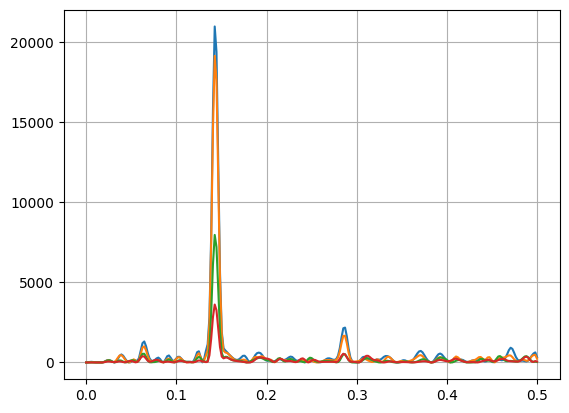

In [ ]:
plt.plot(freq, psd_inquiries)
plt.plot(freq, psd_replies)
plt.plot(freq, psd_accepted)
plt.plot(freq, psd_booking)
# plt.xlim([0, 0.1])
plt.grid()

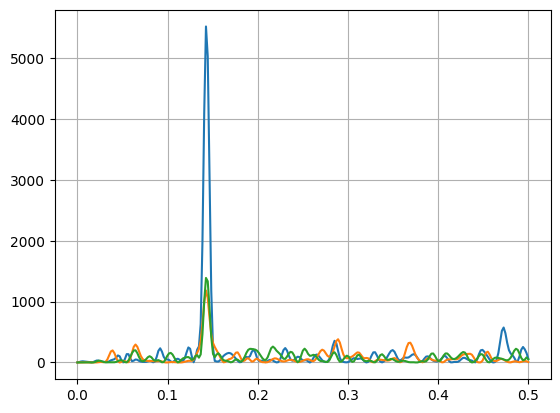

In [ ]:
plt.plot(freq, psd_contact_me)
plt.plot(freq, psd_book_it)
plt.plot(freq, psd_instant_book)
# plt.xlim([0, 0.1])
plt.grid()

Goal: To increase daily and weekly bookings

In [ ]:
plt.plot(booking_rate)

NameError: ignored

In [ ]:
df_master[['ts_interaction_first']]

NameError: ignored